# Read in and clean JOA text data
- Andrew J. Graves
- Start date: 6/11/24

## Import modules

In [0]:
import os
import re
import pandas as pd
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

# Function for stripping markup tags
def remove_markup_from_joa(joa_text, remove_numbers=True):
    '''
    Removes markup from JOA text. Currently replaces strings 
    within (including the symbols themselves) "<>", "&;". 
    Also removes the tab symbol \	 and "?" marks

    Parameters
    ----------
        joa_text (str): The JOA text to remove markup from
        remove_numbers (bool): Whether or not to remove numbers from text. Defaults to True

    Returns
    -------
        joa_text_clean (str): The JOA text with markup removed
    '''
    # Removes strings within < >, & ;, as well as tabs and question marks
    joa_regex = '<.*?>|&.*?;|\t|\?'

    if remove_numbers:
        # Adds numbers to regex string if those need to be removed
        joa_regex += '|\d+'
    # Replaces regex detections with empty string
    joa_text_clean = re.sub(joa_regex, '', joa_text)
    
    return joa_text_clean

## Read in data (updated subset as of 6/24)

In [0]:
# Specify number of files to read in
n_files = 80

# Specify path to JOA data
datapath = '/Volumes/usaml_prd/default/mldev/Zelda/USAJobs_2022-June24/'

# Read in JOA parquet files and store in Pandas DataFrame

# Not including Minimum_Amount and Maximum_Amount b/c of locality differences
# e.g. salary differences will be due to locality rather than purely grade
nontext_cols = ['USAJOBS_Control_Number', 'Hiring_Department_Name', 'Hiring_Agency_Name', 'Hiring_Path',
                'Minimum_Grade', 'Maximum_Grade', 'Pay_Scale', 'Position_Open_Date', 
                'Series', 'Series_Title', 'Minimum_Amount', 'Maximum_Amount']

# Specify JOA text columns
text_cols = ['Duties', 'Duties_List', 'Requirements_Qualifications']

# Get all file names for JOA data
files = [f for f in os.listdir(datapath) if 'part' in f]

# Initialize empty DataFrame
df = pd.DataFrame(columns=nontext_cols + text_cols)

# Loop through files and add to list
for file in files[0:n_files]:
    # Read in the parquet file
    temp = pd.read_parquet(f"{datapath}{file}", columns=nontext_cols + text_cols)
    # Subset for relevant columns and append to final data set
    df = pd.concat([df, temp])
    # Drop multiple locations by returning unique control numbers
    # Need to do this on full df b/c same control number could exist across files
    # Doing it within the for-loop to save memory
    df.drop_duplicates(subset=['USAJOBS_Control_Number'], inplace=True)

# Clear up some memory space by deleting temp
del temp

# Reset index for consistency
df.reset_index(drop=True, inplace=True)

## Clean the data 

In [0]:
# Remove markup to clean up text columns
for col in text_cols:
    df[col] = df[col].fillna('') \
        .apply(lambda x: remove_markup_from_joa(x)) \
        .reset_index(drop=True)

# Concatenate the major duties
df['major_duties'] = df[['Duties', 'Duties_List']].fillna('').sum(axis=1)

# Make all columns lower-case for consistency
df.columns = df.columns.str.lower()

# Drop the duties across the separated columns
# Only retain the unified column major_duties
df.drop(['duties', 'duties_list'], axis=1, inplace=True)

# These are the NA encodings I found, there could be more
na_encodings = ['NULL', 'N/A', 'NA']

# Keep original value if not in na_encodings
# else replace with None
df = df.where(~df.isin(na_encodings), None)

General facts about this dataset to get a sense of its underlying composition:

In [0]:
print(f'Here are the final column names:\n\n {df.columns}\n---\n')
# Control number is the primary key for the JOA
if len(df.usajobs_control_number.unique()) == df.shape[0]:
  print('Control number is the primary key.\n---')

# Finding the percentage of jobs that are GS or assigned to more than 1 series
print(f'{(df.pay_scale == "GS").sum() / df.shape[0] * 100:.2f}% of these jobs are GS.')
print(f'{(df.series.astype("str").str.len() > 4).sum() / df.shape[0] * 100:.2f}% jobs are assigned more than 1 series.\n---')

# Number of agencies and departments (ignoring sub-agencies given high number of unique values)
print(f'{len(df.hiring_agency_name.unique())} hiring agencies total included.')
print(f'{len(df.hiring_department_name.unique())} hiring departments total included.\n---')

# These JOAs go back to 2021 and through 2023
print(f'Earliest date: {pd.to_datetime(df.position_open_date).min().date()}')
print(f'Latest date: {pd.to_datetime(df.position_open_date).max().date()}')

Here are the final column names:

 Index(['usajobs_control_number', 'hiring_department_name',
       'hiring_agency_name', 'hiring_path', 'minimum_grade', 'maximum_grade',
       'pay_scale', 'position_open_date', 'series', 'series_title',
       'minimum_amount', 'maximum_amount', 'requirements_qualifications',
       'major_duties'],
      dtype='object')
---

Control number is the primary key.
---
69.89% of these jobs are GS.
1.79% jobs are assigned more than 1 series.
---
516 hiring agencies total included.
27 hiring departments total included.
---
Earliest date: 2021-01-04
Latest date: 2027-05-26


## Descriptive Visualizations

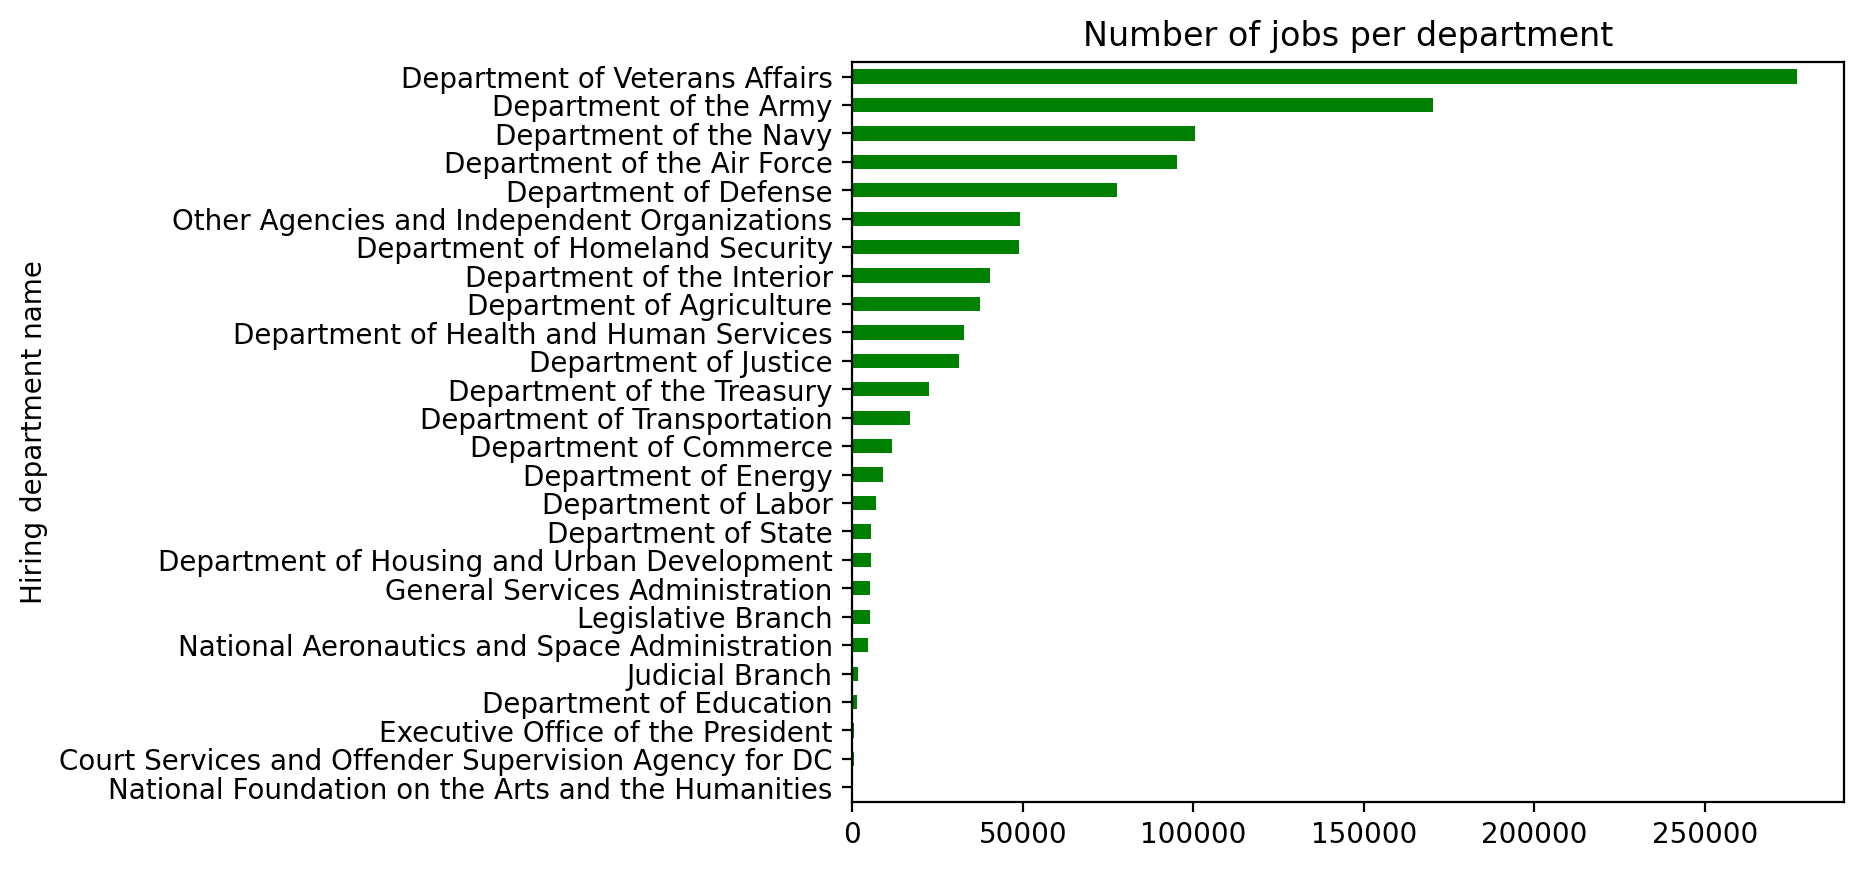

In [0]:
top_depts = df.groupby('hiring_department_name') \
    .count().usajobs_control_number.sort_values() 

top_depts.plot.barh(ylabel='Hiring department name',
               title='Number of jobs per department',
               color='green');

In [0]:
# Specify output path for JOAA data
out_path = '/Volumes/usaml_prd/default/mldev/Zelda/JOAA/'

df.to_csv(out_path + 'usajobs_jan21_june24', chunksize=1024)